In [4]:
import geopandas as gpd 
import pandas as pd
from shapely import ops
import os
import shapely
import numpy as np
import psycopg2
import networkx as nx
import multiprocessing as mp
from shapely.geometry import LineString
shapely.speedups.enable()

%matplotlib inline 

### Load the Dataset

Here we will be using the created "pedestrian network" dataset created by the DAV team at the City of Toronto. We'll then create a network using the Networkx library and the "create_graph" function defined in this notebook. 



In [56]:
con = psycopg2.connect(database="walkability", user="mtenney", password="12qwaszx!@",
    host="172.19.118.205",port="5432")
pednet= gpd.read_postgis('SELECT * FROM compliance.att_pednet_all_in',con)
G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight


In [ ]:
G.edges(data=True)

### Take the graph and setup dataframe to load into Urban Access object.

In [6]:
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [7]:
for ix, node in nodes.iterrows():
    indicies = edges[edges.to == node.xy].index
    edges.loc[indicies,'to'] = ix
    indicies = edges[edges['from'] == node.xy].index
    edges.loc[indicies,'from'] = ix

### Create the pandana network with the dataframe - using integer id's for nodes to/from

In [48]:
import pandana as pdna
from pandana import Network
transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from"],
                               edges["to"],                          
                               pd.DataFrame([edges.length]).T,
                               twoway=True)


/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


### Save the network to load again later

In [11]:
transit_ped_net.save_hdf5('/media/DATADRIVE/walkability/ped_net_final_.hd5')

/opt/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


FOLLOW THIS TUTORIAL
--Load building centroids

http://udst.github.io/pandana/tutorial.html

In [49]:
transit_ped_net.precompute(3000)

In [18]:
schools = gpd.read_postgis('SELECT * FROM compliance.school',con)


In [50]:


tmp = [-79.639273,43.580253,-79.113219,43.855442]

# Reordered for Pandana functions
bbox = [tmp[1], tmp[0], tmp[3], tmp[2]]

x, y = schools.x, schools.y
schools["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(schools["node_ids"], name="school")



/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [53]:
transit_ped_net.set_pois("school", 2000, 10, schools.x, schools.y)
a= transit_ped_net.nearest_pois(2000, "school", num_pois=10)

/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [47]:
transit_ped_net.poi_category_names

[      objectid      geo_id                                               name  \
 0            1    565242.0                             BREBEUF COLLEGE SCHOOL   
 1            2  11467213.0                                BRIAN PUBLIC SCHOOL   
 2            3   8344927.0                          BRIARCREST JUNIOR SCHOOL    
 3            4    312084.0                    BRIDLEWOOD JUNIOR PUBLIC SCHOOL   
 4            5    313306.0            BRIMWOOD BOULEVARD JUNIOR PUBLIC SCHOOL   
 5            6   7515119.0                          BROADACRES JUNIOR SCHOOL    
 6            7    492477.0                           BROADLANDS PUBLIC SCHOOL   
 7            8   9780839.0                         BROCK JUNIOR PUBLIC SCHOOL   
 8            9    788987.0                           BROCKTON LEARNING CENTRE   
 9           10    493354.0                           BROOKHAVEN PUBLIC SCHOOL   
 10          11  14248664.0                            BROOKSIDE PUBLIC SCHOOL   
 11          12 

(<mpl_toolkits.basemap.Basemap at 0x7f2fa33d3e48>,
 <Figure size 1440x1440 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2f967b6668>)

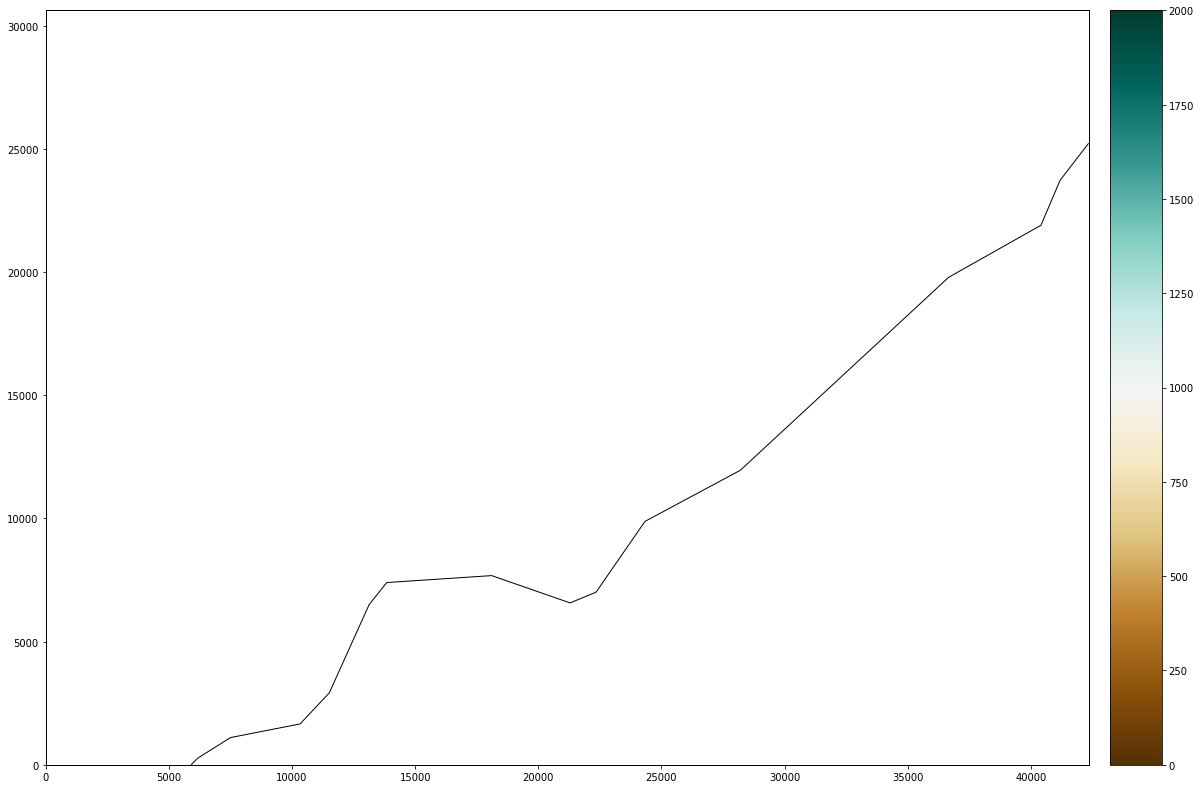

In [55]:
transit_ped_net.plot(a[1], bbox=bbox,
         fig_kwargs={'figsize': [20, 20]},
         bmap_kwargs={'suppress_ticks': False,
                      'resolution': 'h', 'epsg': '2019'},
         plot_kwargs={'cmap': 'BrBG', 's': 8, 'edgecolor': 'none'})

In [2]:
def create_graph(gdf, precision=9, simplify=1):
    '''Create a networkx DiGraph given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
    # The geometries sometimes have tiny end parts - get rid of those!
    gdf.geometry = gdf.geom.simplify(simplify)

    #G = nx.DiGraph()
    G = nx.Graph()

    # TODO: converting to string is probably unnecessary - keeping float may be
    # faster
    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    # az1 is the azimuth of the first segment of the geometry (point into the
    # geometry), az2 is for the last segment (pointing out of the geometry)
    def add_edges(row, G):
        geom = row.geom
        coords = list(geom.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
        fwd_attr['geometry']=  geom
        fwd_attr['length']=  geom.length
#         fwd_attr['az1']=  azimuth_cartesian(coords[0], coords[1])
#         fwd_attr['az2']=  azimuth_cartesian(coords[-2], coords[-1])
        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

In [65]:
from multiprocessing import Pool
import time
import itertools

import matplotlib.pyplot as plt
import networkx as nx


def chunks(l, n):
    """Divide a list of nodes `l` in `n` chunks"""
    l_c = iter(l)
    while 1:
        x = tuple(itertools.islice(l_c, n))
        if not x:
            return
        yield x


def _betmap(G_normalized_weight_sources_tuple):
    """Pool for multiprocess only accepts functions with one argument.
    This function uses a tuple as its only argument. We use a named tuple for
    python 3 compatibility, and then unpack it when we send it to
    `betweenness_centrality_source`
    """
    return nx.betweenness_centrality_source(*G_normalized_weight_sources_tuple)


def betweenness_centrality_parallel(G, processes=11):
    """Parallel betweenness centrality  function"""
    p = Pool(processes=processes)
    node_divisor = len(p._pool) * 4
    node_chunks = list(chunks(G.nodes(), int(G.order() / node_divisor)))
    num_chunks = len(node_chunks)
    bt_sc = p.map(_betmap,
                  zip([G] * num_chunks,
                      [True] * num_chunks,
                      [None] * num_chunks,
                      node_chunks))

    # Reduce the partial solutions
    bt_c = bt_sc[0]
    for bt in bt_sc[1:]:
        for n in bt:
            bt_c[n] += bt[n]
    return bt_c


if __name__ == "__main__":
    print("")
    print("Computing betweenness centrality for:")
    print(nx.info(G))
    print("\tParallel version")
    start = time.time()
    bt = betweenness_centrality_parallel(G)
    print("\t\tTime: %.4F" % (time.time() - start))
    print("\t\tBetweenness centrality for node 0: %.5f" % (bt[0]))
#     print("\tNon-Parallel version")
#     start = time.time()
#     bt = nx.betweenness_centrality(G)
#     print("\t\tTime: %.4F seconds" % (time.time() - start))
#     print("\t\tBetweenness centrality for node 0: %.5f" % (bt[0]))



Computing betweenness centrality for:
Name: 
Type: Graph
Number of nodes: 63217
Number of edges: 85611
Average degree:   2.7085
	Parallel version
		Time: 6899.0067


KeyError: 0

In [63]:
print("\t\tBetweenness centrality for node 0: %.5f" % (bt[0]))


NameError: name 'bt' is not defined